Epoch 1: CNN Test Acc=0.9682, Hybrid Test Acc=0.9719
Epoch 2: CNN Test Acc=0.9825, Hybrid Test Acc=0.9645
Epoch 3: CNN Test Acc=0.9847, Hybrid Test Acc=0.9851
Epoch 4: CNN Test Acc=0.9875, Hybrid Test Acc=0.9784
Epoch 5: CNN Test Acc=0.9876, Hybrid Test Acc=0.9880
Epoch 6: CNN Test Acc=0.9866, Hybrid Test Acc=0.9892
Epoch 7: CNN Test Acc=0.9911, Hybrid Test Acc=0.9889
Epoch 8: CNN Test Acc=0.9893, Hybrid Test Acc=0.9918
Epoch 9: CNN Test Acc=0.9912, Hybrid Test Acc=0.9894
Epoch 10: CNN Test Acc=0.9923, Hybrid Test Acc=0.9933
Epoch 11: CNN Test Acc=0.9924, Hybrid Test Acc=0.9938
Epoch 12: CNN Test Acc=0.9930, Hybrid Test Acc=0.9943
Epoch 13: CNN Test Acc=0.9934, Hybrid Test Acc=0.9949
Epoch 14: CNN Test Acc=0.9937, Hybrid Test Acc=0.9946
Epoch 15: CNN Test Acc=0.9938, Hybrid Test Acc=0.9950


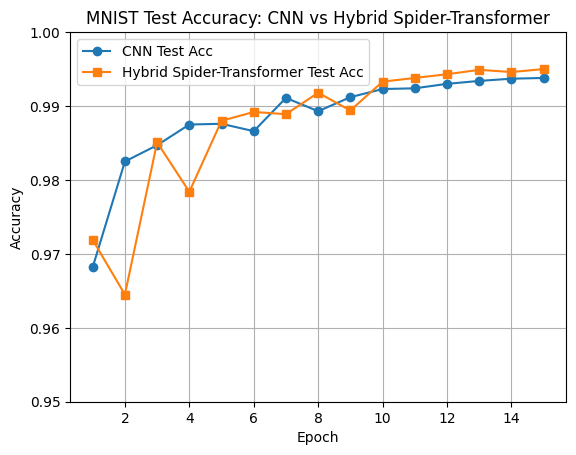

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import math
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# ----------------------------
# MNIST Data with Augmentation
# ----------------------------
train_transform = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomAffine(0, translate=(0.15,0.15)),
    transforms.ToTensor()
])
test_transform = transforms.Compose([transforms.ToTensor()])

train_ds = datasets.MNIST(root='./data', train=True, download=True, transform=train_transform)
test_ds = datasets.MNIST(root='./data', train=False, download=True, transform=test_transform)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False)

# ----------------------------
# CNN Baseline
# ----------------------------
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,32,3,padding=1)
        self.conv2 = nn.Conv2d(32,64,3,padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(64*14*14,128)
        self.fc2 = nn.Linear(128,10)
    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# ----------------------------
# Ultra-Optimized Hybrid Spider-Transformer
# ----------------------------
class PatchTransformer(nn.Module):
    def __init__(self, img_size=28, patch_size=4, emb_dim=192, num_heads=12, num_layers=6, dropout=0.1):
        super().__init__()
        self.patch_embed = nn.Conv2d(1, emb_dim, kernel_size=patch_size, stride=patch_size)
        self.num_patches = (img_size // patch_size)**2
        self.pos_embed = nn.Parameter(torch.randn(1, self.num_patches, emb_dim))
        encoder_layer = nn.TransformerEncoderLayer(d_model=emb_dim, nhead=num_heads,
                                                   dim_feedforward=384, dropout=dropout)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B = x.size(0)
        x = self.patch_embed(x).flatten(2).transpose(1,2)
        x = x + self.pos_embed
        x = self.transformer(x)
        x = x.mean(dim=1)
        x = self.dropout(x)
        return x

class AdaptiveMultiScalePolarSampler(nn.Module):
    def __init__(self, rings_list=[10], angles_list=[36], scales_list=[(0.0,1.0)]):
        super().__init__()
        self.rings_list = rings_list
        self.angles_list = angles_list
        self.scales_list = scales_list

    def forward(self, feat):
        B,C,H,W = feat.shape
        device = feat.device
        outputs=[]
        for rings, angles, (inner, outer) in zip(self.rings_list, self.angles_list, self.scales_list):
            a_vals = torch.linspace(0, 2*math.pi, steps=angles, device=device)
            r_min = inner*min(H,W)
            r_max = outer*min(H,W)
            rr = torch.linspace(r_min, r_max, rings, device=device).view(rings,1)
            rr_exp = rr.expand(rings, angles)
            aa = a_vals.view(1,angles).expand(rings,angles)
            cx,cy = (W-1)/2,(H-1)/2
            pos_x = cx + rr_exp*torch.cos(aa)
            pos_y = cy + rr_exp*torch.sin(aa)
            norm_x = (pos_x/(W-1))*2-1
            norm_y = (pos_y/(H-1))*2-1
            grid = torch.stack([norm_x,norm_y],dim=-1).unsqueeze(0).expand(B,-1,-1,-1)
            out = F.grid_sample(feat, grid, mode='bilinear', padding_mode='border', align_corners=True)
            outputs.append(out)
        return torch.cat(outputs, dim=2)

class SpiderGraphConv(nn.Module):
    def __init__(self, channels, steps=4):
        super().__init__()
        self.steps=steps
        self.conv = nn.Conv2d(channels, channels, 3, padding=1)
        self.act=nn.ReLU(inplace=True)
    def forward(self,x):
        out=x
        for _ in range(self.steps):
            out = self.act(self.conv(out)+out)
        return out

class CrossAttentionFusion(nn.Module):
    def __init__(self, feat_dim1, feat_dim2):
        super().__init__()
        self.q = nn.Linear(feat_dim1, feat_dim1)
        self.k = nn.Linear(feat_dim2, feat_dim1)
        self.v = nn.Linear(feat_dim2, feat_dim1)
    def forward(self, x1, x2):
        q = self.q(x1).unsqueeze(1)
        k = self.k(x2).unsqueeze(1)
        v = self.v(x2).unsqueeze(1)
        attn = torch.softmax((q @ k.transpose(-2,-1)) / math.sqrt(q.size(-1)), dim=-1)
        fused = (attn @ v).squeeze(1) + x1
        return fused

class HybridSpiderTransformer(nn.Module):
    def __init__(self):
        super().__init__()
        self.transformer = PatchTransformer()
        self.polar_conv = nn.Sequential(
            nn.Conv2d(1,32,3,padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.Conv2d(32,64,3,padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.Conv2d(64,64,3,padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.Dropout(0.15)
        )
        self.sampler = AdaptiveMultiScalePolarSampler()
        self.graph = SpiderGraphConv(64)
        self.fusion = CrossAttentionFusion(feat_dim1=192, feat_dim2=64)
        self.fc = nn.Linear(192,10)

    def forward(self,x):
        trans_feat = self.transformer(x)
        polar_feat = self.polar_conv(x)
        polar_feat = self.sampler(polar_feat)
        polar_feat = self.graph(polar_feat)
        polar_feat = F.adaptive_avg_pool2d(polar_feat,1).squeeze(-1).squeeze(-1)
        fused = self.fusion(trans_feat, polar_feat)
        out = self.fc(fused)
        return out

# ----------------------------
# Training / Testing Functions
# ----------------------------
def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_correct = 0
    for x,y in loader:
        x,y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out,y)
        loss.backward()
        optimizer.step()
        total_correct += (out.argmax(1)==y).sum().item()
    return total_correct/len(loader.dataset)

def test(model, loader, device):
    model.eval()
    total_correct = 0
    with torch.no_grad():
        for x,y in loader:
            x,y = x.to(device), y.to(device)
            out = model(x)
            total_correct += (out.argmax(1)==y).sum().item()
    return total_correct/len(loader.dataset)

# ----------------------------
# Instantiate Models
# ----------------------------
cnn_model = SimpleCNN().to(device)
hybrid_model = HybridSpiderTransformer().to(device)

optimizer_cnn = torch.optim.Adam(cnn_model.parameters(), lr=1e-3)
optimizer_hybrid = torch.optim.AdamW(hybrid_model.parameters(), lr=1e-3, weight_decay=1e-4)

scheduler_cnn = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_cnn, T_max=15)
scheduler_hybrid = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_hybrid, T_max=15)

criterion = nn.CrossEntropyLoss()

# ----------------------------
# Training Loop
# ----------------------------
epochs = 15
cnn_accs, hybrid_accs = [], []

for epoch in range(epochs):
    train_epoch(cnn_model, train_loader, optimizer_cnn, criterion, device)
    train_epoch(hybrid_model, train_loader, optimizer_hybrid, criterion, device)

    cnn_test_acc = test(cnn_model, test_loader, device)
    hybrid_test_acc = test(hybrid_model, test_loader, device)

    cnn_accs.append(cnn_test_acc)
    hybrid_accs.append(hybrid_test_acc)

    scheduler_cnn.step()
    scheduler_hybrid.step()

    print(f'Epoch {epoch+1}: CNN Test Acc={cnn_test_acc:.4f}, Hybrid Test Acc={hybrid_test_acc:.4f}')

# ----------------------------
# Plot Accuracy Comparison
# ----------------------------
plt.plot(range(1, epochs+1), cnn_accs, marker='o', label='CNN Test Acc')
plt.plot(range(1, epochs+1), hybrid_accs, marker='s', label='Hybrid Spider-Transformer Test Acc')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("MNIST Test Accuracy: CNN vs Hybrid Spider-Transformer")
plt.grid(True)
plt.ylim(0.95,1.0)
plt.legend()
plt.show()
